## Classifier for predicting the category of a request to the 1551 service

#### Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import re
import seaborn as sns
from pathlib import Path

#! pip install langdetect
from langdetect import detect

import nltk
from nltk import tokenize
nltk.download('punkt')
import spacy
#!python -m spacy download uk_core_news_sm
import uk_core_news_sm

In [52]:
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

from gensim.models import Doc2Vec
import gensim
from gensim.models.doc2vec import TaggedDocument

In [53]:
from sklearn.metrics import f1_score
import multiprocessing

In [123]:
# Translate russian into Ukrainian with HaggingFace
# ! pip install transformers
# ! pip install sentencepiece
from transformers import MarianMTModel, MarianTokenizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.6 MB/s eta 0:00:00


#### Data Loading

In [10]:
%%time
inpath = Path('C:/N/st/UCU/3sem2022/NLP/M/practice/data3/1551/')
data = []
for infile in inpath.rglob('*.txt'):
    category = infile.stem
    with open(infile, 'r') as inf:
        text = inf.read()
    text_list = text.split('\n\n\n')
    for txt in text_list:
        # Split the chunk into lines
        lines = txt.split('\n')
        # Join the lines
        joined_text = ' '.join(lines[0:])
        # Create a pandas DataFrame with a 'text' column and a 'category' column
        df = pd.DataFrame({'text': [joined_text], 'category': [category]})
        # Append the DataFrame to the 'data' list
        data.append(df)
df = pd.concat(data, ignore_index=True)

CPU times: user 29.9 s, sys: 362 ms, total: 30.3 s
Wall time: 38.4 s


#### Cleaning data

In [11]:
df['complains_id'] = df['text'].str.extract(r'^(\d+)')  #id as number of complain
df['text'] = df['text'].str.replace(r'^(\d+)\n*', '')  # Remove number of complain from text
df = df.dropna(subset=['text', 'complains_id'])   # Drop NA
df = df.drop_duplicates(subset = ["text"])    # Drop dublicates
df['category_id'] = df['category'].factorize()[0]   # Add column for category id
df = df[df["text"].str.len()>5]   # Drop rows with 4 or less tokens

<ipython-input-11-6e6a80829aa7>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace(r'^(\d+)\n*', '')  # Remove number of complain from text
<ipython-input-11-6e6a80829aa7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category_id'] = df['category'].factorize()[0]   # Add column for category id


In [12]:
new_column_order = ["complains_id", "text", "category", "category_id"]
df = df[new_column_order]
df.head(5)

,complains_id,text,category,category_id
0,2759352,Біля сміттєзбірника накопичилася велика куча ...,Вивезення--утилізація-твердих-та-негабаритних-...,0
1,2745387,"Напроти будинку вул. Бестужева 32, поблизу с...",Вивезення--утилізація-твердих-та-негабаритних-...,0
2,3071282,утримання прибудинкової території у незадовіл...,Вивезення--утилізація-твердих-та-негабаритних-...,0
3,3436400,"Жалоба по поводу того , что в прикрепленном п...",Вивезення--утилізація-твердих-та-негабаритних-...,0
4,3423381,"Прошу приняти міри, стосовно сміття яке залиш...",Вивезення--утилізація-твердих-та-негабаритних-...,0


In [13]:
len(df)

103641

There are 103,641 claims in the data set.

#### Language detection
Identify the language of the claims

In [15]:
from tqdm import tqdm
tqdm.pandas()

In [14]:
def langdetect(text):
    try:
        language = detect(text)
    except:
        language = "none"
    return language

In [16]:
%%time
df["language"] = df["text"].progress_apply(lambda x: langdetect(x))

100%|██████████| 103641/103641 [11:11<00:00, 154.32it/s]

CPU times: user 9min 27s, sys: 6.56 s, total: 9min 34s
Wall time: 11min 11s


In [17]:
df.groupby("language").size()

language
bg      328
de        4
en        2
mk      101
pl        3
ru    47383
sk        1
uk    55819
dtype: int64

In [19]:
# Take only text in Ukrainian
df_uk = df[df["language"]=='uk']
df_uk.shape

(55819, 5)

#### Analyze complains in Ukrainian data

In [20]:
df_uk["category"].nunique()

188

There are 188 categories in the data.

In [31]:
cat = df_uk["category"].value_counts()
cat_df = pd.DataFrame({"cat": cat.index, "count": cat.values})
cat_df

,cat,count
0,Відсутність-ГВП,5855
1,Укладання-та-ремонт-асфальтного-покриття,3306
2,Відсутність-опалення,2751
3,Перевірка-дозвільної-документації--демонтаж-...,2028
4,Прибирання-та-санітарний-стан-територій,1677
...,...,...
183,Виток-холодної-води-на-поверхню,50
184,Паркування-на-зеленій-зоні-у-місцях-загальног...,49
185,Відсутність-ГВП-по-стояку,46
186,Питання--що-стосуються-домофонної-системи,44


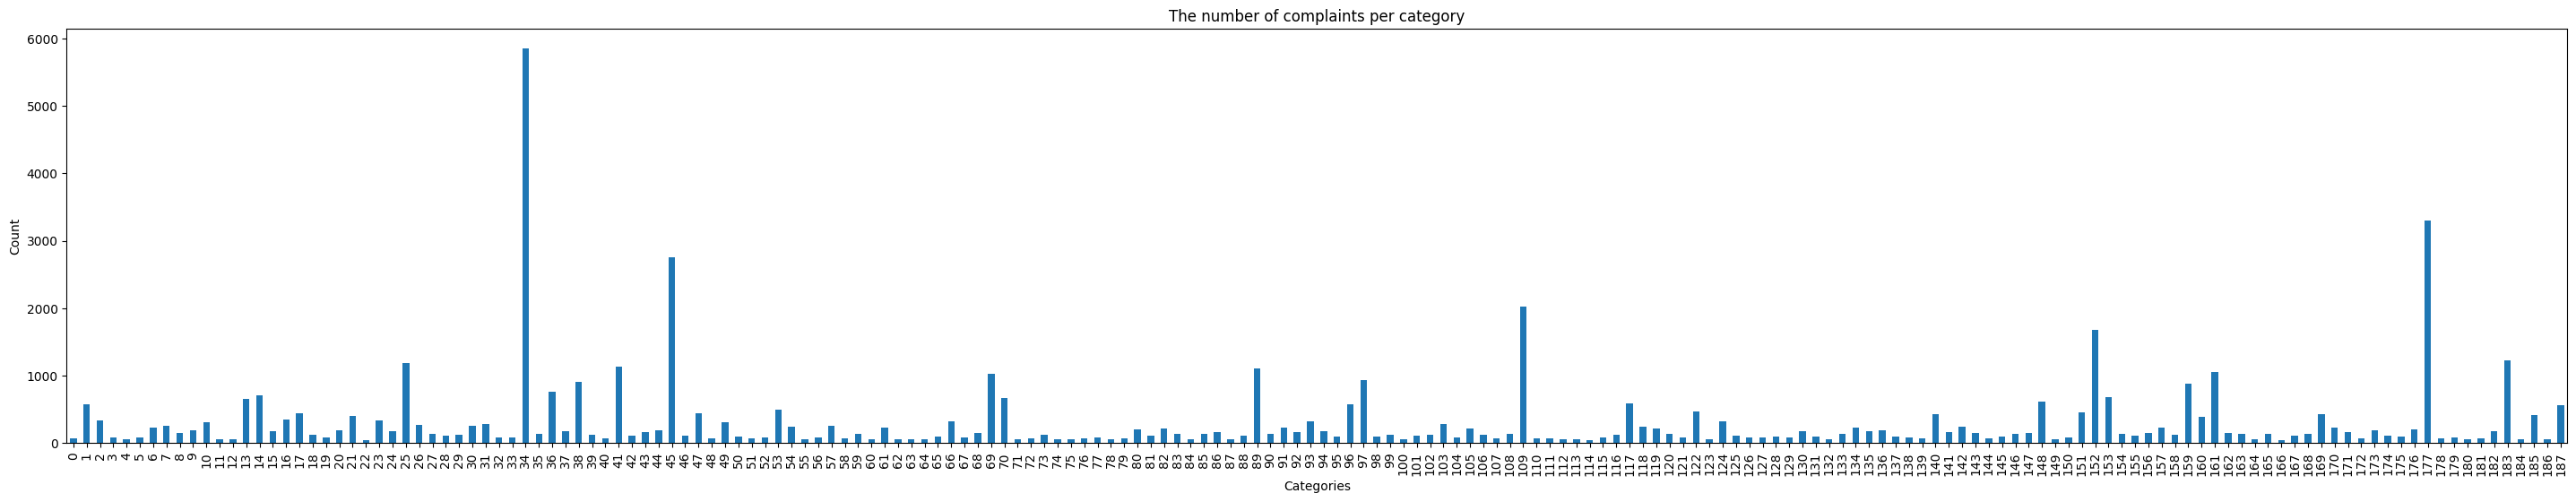

In [30]:
fig = plt.figure(figsize=(36,6))
df_uk.groupby('category_id').text.count().plot.bar(ylim=0)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('The number of complaints per category')
plt.show()

There are 188 categories in the dataset. The number of queries in the categories is not balanced. For example, “Lack of hot water supply” has 5,902 queries, but there are categories with less than 50 queries, such as “Lack of hot water supply by riser”, “Questions concerning intercom system”, “Suggestions and comments on the work of web pages”.

#### Split data on test and train

In [32]:
X = df_uk["text"]
y = df_uk["category"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 108)

In [33]:
print(len(X_train), len(y_train))

44655 44655


#### Baseline model

In [35]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

##### LinearSCV

In [39]:
# Apply LinearSVC
model = LinearSVC()
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

In [40]:
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                                    precision    recall  f1-score   support

                                                                       Інші-Подяки       0.49      0.47      0.48        57
                                                Інші-технічні-недоліки-стану-ліфту       0.50      0.52      0.51       128
               Аварійний--травмонебезпечний-стан-утримання-об-єктів-благоустрою       0.15      0.12      0.14        40
                                            Бажаючі-отримати--Картки-киянина--КК--       1.00      1.00      1.00         9
                               Будівництво--дооблаштування-спортивних-майданчиків       0.58      0.44      0.50        16
                                                                   Будівництво-АЗС       0.60      0.47      0.53        19
                                                         Будівництво-в-нічний-час       0.83      0.42      0.56        12
       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Using LinearSCV, we achieved a weighted  avg of 60% and a macro average F1 of 48%. 
Analyzing the classification report, we see that some categories are very poorly detected as “Технічний-стан-мостів-та-шляхопроводів”, “Стан-зливосточних-систем-проїжджих-частин-та-тротуарів”, “Ремонт-теплотрас--підключення”, "Ремонт-демонтаж-фарбування-елементів-дитячого-майданчику” and "Раціоналізаторські-пропозиції".

Possible reasons:
- the data is noisy
- there is too little data in some categories for the classifier to classify correctly
- data in some categories may overlap

#### Clean the text

- remove unnecessary symbols
- remove stop words
- remove words that are not in the dictionary
- lemmatize words
- remove greetings and words that denote the filing of a complaint. Because these phrases make complaints sound similar, even in different categories.

In [43]:
# Cleaning the text with regular expression
def process_text(input):
    if isinstance(input, str):
        input = " ".join(tokenize.sent_tokenize(input))
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r'[^\w\s]', "", input)
        input = re.sub(r"#\S+", "", input)
        input = re.sub(r'\d', '', input)
        input = input.strip()
        input = input.lower()  # Lower text
    return input

In [44]:
df_uk["text"] = df_uk["text"].apply(process_text)

<ipython-input-44-387e66a661a0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uk["text"] = df_uk["text"].apply(process_text)


In [169]:
# Remove stop words, remove words that do not have vectors, lematize text
nlp = spacy.load("uk_core_news_sm")
def lemmatize_and_filter(text):
    doc = nlp(text)
    # Exclude specific lemmatized tokens
    excluded_tokens = ["добрий", "день", "ранок", "вечір", "просити", "прохання", "пропозиція", "вживати", "заходи", "прийняти", "міра", "скарга", "жалоба"]

    lemmatized_tokens = [token.lemma_ for token in doc if token.has_vector and not token.is_stop and token.lemma_ not in excluded_tokens]
    lemmatized_text = ' '.join(lemmatized_tokens).replace(',', '')

    return lemmatized_text

In [81]:
# Apply the lemmatization function to the 'Clean' column
df_uk['lemmatized_text'] = df_uk['text'].progress_apply(lemmatize_and_filter)

100%|██████████| 55819/55819 [24:19<00:00, 38.24it/s]


In [82]:
df_uk.head(5)

,complains_id,text,category,category_id,language,lemmatized_text
0,2759352,біля сміттєзбірника накопичилася велика куча б...,Вивезення--утилізація-твердих-та-негабаритних-...,0,uk,сміттєзбірник накопичитися великий куча будіве...
1,2745387,напроти будинку вул бестужева поблизу сміттє...,Вивезення--утилізація-твердих-та-негабаритних-...,0,uk,напроти будинок вул бестужева поблизу сміт...
2,3071282,утримання прибудинкової території у незадовіль...,Вивезення--утилізація-твердих-та-негабаритних-...,0,uk,утримання прибудинковий територія незадовільни...
4,3423381,прошу приняти міри стосовно сміття яке залишил...,Вивезення--утилізація-твердих-та-негабаритних-...,0,uk,приняти стосовно сміття який залишити робітник...
5,3048268,просимо вас прийняти адміністративні заходи до...,Вивезення--утилізація-твердих-та-негабаритних-...,0,uk,адміністративний захід мешканець будинок номер...


#### Improve LinearSCV

In [102]:
X = df_uk["lemmatized_text"]
y = df_uk["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=108)

In [103]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [105]:
# Apply LinearSVC
model = LinearSVC()
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))

Testing accuracy 0.6446614116804013


In [87]:
print(classification_report(y_test, y_pred))

                                                                                    precision    recall  f1-score   support

                                                                       Інші-Подяки       0.43      0.35      0.38        57
                                                Інші-технічні-недоліки-стану-ліфту       0.46      0.45      0.46       128
               Аварійний--травмонебезпечний-стан-утримання-об-єктів-благоустрою       0.34      0.28      0.31        40
                                            Бажаючі-отримати--Картки-киянина--КК--       0.75      1.00      0.86         9
                               Будівництво--дооблаштування-спортивних-майданчиків       0.53      0.50      0.52        16
                                                                   Будівництво-АЗС       0.88      0.74      0.80        19
                                                         Будівництво-в-нічний-час       0.73      0.67      0.70        12
       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


With the cleaned data, we improved the weigted accuracy slightly to 63% (previously it was 60%), and also improved macro avg F1 to 53% (previously 48%). But there are still categories that have very low accuracy due to the small amount of data or overlaping with other categories.

#### doc2vec with LinearSCV
ref: https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

In [109]:
train_tagged = [TaggedDocument(words=x.split(' '), tags=[y]) for x,y in zip(X_train, y_train)]
test_tagged = [TaggedDocument(words=x.split(' '), tags=[y]) for x,y in zip(X_test, y_test)]

In [110]:
# Distributed Bag of Words (DBOW). DBOW is the doc2vec model analogous to Skip-gram model in word2vec
cores = multiprocessing.cpu_count()

In [111]:
# Building a Vocabulary
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged)])
model_dbow.train(train_tagged, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

100%|██████████| 44655/44655 [00:00<00:00, 1924939.83it/s]


In [112]:
def vec_for_learning(model, tagged_docs):
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in tagged_docs])
    return regressors, targets

In [113]:
X_train_vec, y_train_vec = vec_for_learning(model_dbow, train_tagged)
X_test_vec, y_test_vec = vec_for_learning(model_dbow, test_tagged)

In [114]:
model = LinearSVC()
model.fit(X_train_vec, y_train_vec)
y_pred_vec = model.predict(X_test_vec)
accuracy = accuracy_score(y_test_vec, y_pred_vec)
print('Testing accuracy %s' % accuracy_score(y_test_vec, y_pred_vec))

Testing accuracy 0.5775707631673236


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [115]:
print(classification_report(y_test_vec, y_pred_vec))

                                                                                    precision    recall  f1-score   support

                                                                       Інші-Подяки       0.45      0.30      0.36        57
                                                Інші-технічні-недоліки-стану-ліфту       0.50      0.45      0.48       128
               Аварійний--травмонебезпечний-стан-утримання-об-єктів-благоустрою       0.29      0.28      0.28        40
                                            Бажаючі-отримати--Картки-киянина--КК--       0.73      0.89      0.80         9
                               Будівництво--дооблаштування-спортивних-майданчиків       0.50      0.38      0.43        16
                                                                   Будівництво-АЗС       0.80      0.63      0.71        19
                                                         Будівництво-в-нічний-час       0.78      0.58      0.67        12
       

With doc2vec, the accuracy results dropped from 63% to 58%, and macro avg F1 from 53% to 45%. Probably, the categories are very close to each other, which is why there is confusion. 

#### Balancing data
We will add more data for better classification. Let's translate the data from Russian.

##### Categories which we need to upsample

For which categories we need to add data:
- data from categories with less than 500 complaints
- data from categories where F1 score is below 0.5 (because some categories with little data still stand out very well, perhaps because they have more words unique to the category)

In [97]:
# Take all categories where the number of the complains are less than 500
category_counts =df_uk['category'].value_counts()
small_categories = category_counts[category_counts < 501].index.tolist()

In [98]:
print("Категорії, які мають менше ніж 500 скарг: ", len(small_categories))

Категорії, які мають менше ніж 500 скарг:  164


In [116]:
# Take categories that have F1 score lower than 0.5
report = classification_report(y_test_vec, y_pred_vec, output_dict=True)
category_lowerF1 = []
for class_name, metrics in report.items():
    if class_name != 'accuracy' and class_name != 'macro avg' and class_name != 'weighted avg':
        f1_score = metrics['f1-score']

        # Check if F1 score is lower than 0.5
        if f1_score < 0.5:
          category_lowerF1.append(class_name)

In [117]:
print("Категорії, які мають F1 score менший ніж 0.5: ", len(category_lowerF1))

Категорії, які мають F1 score менший ніж 0.5:  106


In [118]:
# Take categories which has lower number of complains and lower F1 score
filtered_catagories = set(category_lowerF1).intersection(small_categories)
print("Категорії, для яких додаємо дані: ", len(filtered_catagories))

Категорії, для яких додаємо дані:  99


In [119]:
filtered_catagories= list(filtered_catagories)

In [120]:
# Take all text in russian and choose our category
df_ru = df[df["language"]=='ru']
df_ru.shape

(47383, 5)

In [121]:
df_ru_sm = df_ru[df_ru["category"].isin(filtered_catagories)]
len(df_ru_sm)

11549

##### Translate

In [124]:
%%time
model_name = "Helsinki-NLP/opus-mt-ru-uk"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/297M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

CPU times: user 3.94 s, sys: 990 ms, total: 4.93 s
Wall time: 12.1 s


In [ ]:
df_uk_sm['text_translated'] = df_ru_sm['text'].apply(lambda x: tokenizer.decode(model.generate(**tokenizer(x, return_tensors="pt", truncation=True))[0], skip_special_tokens=True))

##### Clean new data

In [168]:
df_uk_sm.head(5)

,complains_id,text_translated,category,language
0,3436400,"Що жалоба з приводу того, що в прикріпленому л...",Вивезення--утилізація-твердих-та-негабаритних-...,uk
1,3060925,Було навернення Н-5960(убір сміття). Було пров...,Вивезення--утилізація-твердих-та-негабаритних-...,uk
2,2896174,"Доброго дня, будь ласка, наведіть порядок біля...",Вивезення--утилізація-твердих-та-негабаритних-...,uk
3,2840264,Виводити велике сміття з під будинку градинськ...,Вивезення--утилізація-твердих-та-негабаритних-...,uk
4,3168784,Відсилаючи повідомлення від 20.02.2015 з проха...,Вивезення--утилізація-твердих-та-негабаритних-...,uk


In [170]:
# Clean and lemmatize
df_uk_sm["text_translated"] = df_uk_sm["text_translated"].apply(process_text)
df_uk_sm['lemmatized_text'] = df_uk_sm['text_translated'].progress_apply(lemmatize_and_filter)

100%|██████████| 9132/9132 [03:42<00:00, 41.12it/s]


In [171]:
df_uk_sm['lemmatized_text'].head(10)

0    привід прикріплений лист обіцяно влада очистит...
1    навернення нубір сміття провести робота наверн...
2    навести порядок будинок адреса ул озерний    п...
3    виводити великий сміття будинок градинська   л...
4    відсилаючи повідомлення   прибрати будівельний...
5    добрый звертатися заява вивезення автомобільни...
6    фотоматеріали стосуватися доступ ф підтверджув...
7    систематично вивозити сміття твердий побутовий...
8                    вивезти діван смітєвого контейнер
9    пришвартований територія волгоградський лежати...
Name: lemmatized_text, dtype: object

We can see that there are mistakes in the translation, we can correct the mistakes in the future.

##### Concatenate old and new datasets

In [173]:
# Rename column for clean concatenate
df_uk_sm = df_uk_sm.rename(columns={"text_translated": "text"})

# Remove column "category_id"
df_uk = df_uk.drop("category_id", axis=1)

In [176]:
df_full = pd.concat([df_uk,df_uk_sm])
df_full['category_id'] = df_full['category'].factorize()[0]
df_full.head(5)

,complains_id,text,category,language,lemmatized_text,category_id
0,2759352,біля сміттєзбірника накопичилася велика куча б...,Вивезення--утилізація-твердих-та-негабаритних-...,uk,сміттєзбірник накопичитися великий куча будіве...,0
1,2745387,напроти будинку вул бестужева поблизу сміттє...,Вивезення--утилізація-твердих-та-негабаритних-...,uk,напроти будинок вул бестужева поблизу сміт...,0
2,3071282,утримання прибудинкової території у незадовіль...,Вивезення--утилізація-твердих-та-негабаритних-...,uk,утримання прибудинковий територія незадовільни...,0
4,3423381,прошу приняти міри стосовно сміття яке залишил...,Вивезення--утилізація-твердих-та-негабаритних-...,uk,приняти стосовно сміття який залишити робітник...,0
5,3048268,просимо вас прийняти адміністративні заходи до...,Вивезення--утилізація-твердих-та-негабаритних-...,uk,адміністративний захід мешканець будинок номер...,0


In [177]:
len(df_full)

64951

#### Improve LinearSCV

In [178]:
# Split data
X = df_full["lemmatized_text"]
y = df_full["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=108)

In [179]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [180]:
# Apply LinearSVC
model = LinearSVC()
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))

Testing accuracy 0.6143483950427219


In [158]:
print(classification_report(y_test, y_pred))

                                                                                    precision    recall  f1-score   support

                                                                       Інші-Подяки       0.36      0.29      0.32       101
                                                Інші-технічні-недоліки-стану-ліфту       0.43      0.37      0.40       121
               Аварійний--травмонебезпечний-стан-утримання-об-єктів-благоустрою       0.27      0.22      0.24        81
                                            Бажаючі-отримати--Картки-киянина--КК--       0.67      1.00      0.80        10
                               Будівництво--дооблаштування-спортивних-майданчиків       0.56      0.47      0.51        30
                                                                   Будівництво-АЗС       0.89      0.74      0.81        23
                                                         Будівництво-в-нічний-час       0.54      0.71      0.61        21
       

The addition of new data slightly reduced the weighted F1 accuracy from 63% to 60%, but increased the macro avg F1 by 1% and now stands at 54%. Only one category is not defined at all - “Відсутність-ГВП-по-стояку”, because it has 20 complaints.

The reasons why the accuracy has not changed much may be that:
- the Russian dataset also does not have much data for categories that are poorly defined;
- categories can be very similar.

What can be improved to achieve a better result:
- Correct errors
- Create meta groups, which will include a certain number of groups that share words or activities. Calculate the accuracy of meta groups and subgroups in each meta group.